In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
import random
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from mpl_toolkits.mplot3d import Axes3D
writer = SummaryWriter()

In [2]:
DATA_PATH = 'C:/Users/user/Desktop/THESIS YLIKO/batch13.txt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

c:\users\user\pymol\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
def load_data(path):
    # read in from csv
    expressions = pd.read_csv(DATA_PATH, sep=',')
    subtypes = expressions['Batch']
    subtypes
    expressions = expressions.drop(columns=['x','Batch', 'Cell','Group'])

    index = list(subtypes.index[subtypes == 'Batch1']) + \
    list(subtypes.index[subtypes == 'Batch2']) + \
    list(subtypes.index[subtypes == 'Batch4']) + \
    list(subtypes.index[subtypes == 'Batch3'])
    random.shuffle(index)
    expressions = expressions.iloc[index, :].astype('float32')
    subtypes = subtypes.iloc[index]
    #y=y.iloc[index]
    standardizer = preprocessing.StandardScaler()
    expressions = standardizer.fit_transform(expressions) 
    
    return expressions, standardizer, subtypes#, y
    
def numpyToTensor(expressions):
    x_train = torch.from_numpy(expressions).to(device)
    return x_train

In [4]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.expressions, self.standardizer,self.subtypes= load_data(DATA_PATH)
        #,self.y = load_data(DATA_PATH)
        self.expressions = numpyToTensor(self.expressions)
        self.len=self.expressions.shape[0]
        
    def __getitem__(self, item):
        return self.expressions[item]

    def __len__(self):
        return self.len

In [5]:
data_set = DataBuilder(DATA_PATH)
trainloader = DataLoader(dataset=data_set, batch_size=120)


In [6]:
class Autoencoder(nn.Module):
    def __init__(self, D_in, H, H2, latent_dim=80):
        
        # Encoder
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        

        #         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        #         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        #         # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar


In [7]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [8]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        #if self.bias is not None:
        #    self.bias.data.uniform_(-stdv, stdv)
        #print("BLABLABLA",m.bias.data.fill_(0))

In [9]:
D_in = data_set.expressions.shape[1]
H = 100
H2 = 100
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_mse = customLoss()

epochs = 20000
log_interval = 100
val_losses = []
train_losses = []

In [10]:
mu_output = []
save_recon = []
save_data = []
def train(epoch):
    model.train()
    train_loss = 0
    trainloader
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data) 
        mu_tensor = mu   
        mu_output.append(mu_tensor)
        mures = torch.cat(mu_output, dim=0)  
        #print("REC",recon_batch[1][1])
        #print("DATA",data[1][1])
        
        loss = loss_mse(recon_batch, data, mu, logvar)
        if(loss<0):
            print(loss)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    if epoch % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        writer.add_scalar("LOSS",train_loss / len(trainloader.dataset), epoch)
        train_losses.append(train_loss / len(trainloader.dataset))
    if epoch == 19900:
        print("REC",recon_batch[1])
        print("data",data[1])
for epoch in range(1, epochs + 1):
    train(epoch)
writer.flush()

====> Epoch: 100 Average loss: 111.4665
====> Epoch: 200 Average loss: 52.3835
====> Epoch: 300 Average loss: 37.8018
====> Epoch: 400 Average loss: 32.9635
====> Epoch: 500 Average loss: 32.6851
====> Epoch: 600 Average loss: 28.7534
====> Epoch: 700 Average loss: 27.7525
====> Epoch: 800 Average loss: 26.8301
====> Epoch: 900 Average loss: 26.7626
====> Epoch: 1000 Average loss: 25.6931
====> Epoch: 1100 Average loss: 24.4377
====> Epoch: 1200 Average loss: 24.9904
====> Epoch: 1300 Average loss: 24.7875
====> Epoch: 1400 Average loss: 23.7994
====> Epoch: 1500 Average loss: 23.9941
====> Epoch: 1600 Average loss: 23.3142
====> Epoch: 1700 Average loss: 22.2669
====> Epoch: 1800 Average loss: 22.9846
====> Epoch: 1900 Average loss: 21.7714
====> Epoch: 2000 Average loss: 23.1488
====> Epoch: 2100 Average loss: 22.3518
====> Epoch: 2200 Average loss: 21.4258
====> Epoch: 2300 Average loss: 22.1807
====> Epoch: 2400 Average loss: 25.8399
====> Epoch: 2500 Average loss: 21.4941
====> Ep

====> Epoch: 20000 Average loss: 8.8986


In [11]:
writer.close()

[[-0.11250879 -0.03603715  2.4696095  ...  1.7680264  -0.67105645
   0.18708391]
 [-0.11250879  0.19984238 -0.72819585 ... -1.1819189  -0.554683
   0.12026823]
 [-0.11250879  0.22605121 -0.72819585 ... -1.1560421  -0.6055964
  -0.3808494 ]
 ...
 [-0.11250879 -0.40296087 -0.72819585 ... -1.2336723  -0.87470996
  -0.98219055]
 [-0.11250879 -0.219499   -0.72819585 ... -1.259549   -0.74378985
  -0.8485592 ]
 [-0.11250879 -0.8747199  -0.17205581 ... -0.4832476  -0.26374948
  -0.81515133]]


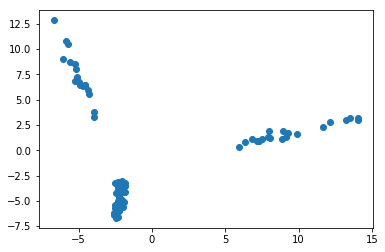

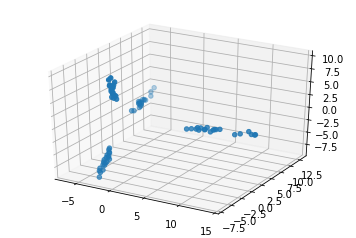

In [16]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt




x_pca, standardizer, data = load_data(DATA_PATH)
print(x_pca)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
#finalDf = pd.concat([principalDf, pd.DataFrame(data)], axis = 1)
#finalDf.head()


#ax = plt.axes(projection='2d')
fig,ax = plt.subplots()

# Data for two-dimensional scattered points
#winetype = principalDf.iloc[:,2].values
xdata = principalDf.iloc[:,0].values
ydata = principalDf.iloc[:,1].values
ax.scatter(xdata, ydata)#, c=winetype);
max(xdata)
#max(ydata)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


xdata = principalDf.iloc[:,0].values
ydata = principalDf.iloc[:,1].values
zdata = principalDf.iloc[:,2].values
ax.scatter(xdata, ydata,zdata)


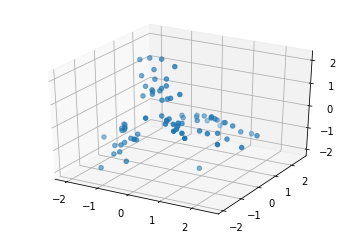

In [15]:
mu_pca = mu_output[19999].cpu().detach().numpy()

#print(mu_pca)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(mu_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

#finalDf = pd.concat([principalDf, pd.DataFrame(data)], axis = 1)
#finalDf.head()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


xdata = principalDf.iloc[:,0].values
ydata = principalDf.iloc[:,1].values
zdata = principalDf.iloc[:,2].values
ax.scatter(xdata, ydata,zdata)
